In [ ]:
!pip install statsmodels==0.13.0

     |████████████████████████████████| 9.8 MB 13.1 MB/s 
     |████████████████████████████████| 233 kB 5.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import math
from scipy.stats import bernoulli, norm
import scipy as sp
from tabulate import tabulate

In [ ]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

# 1. Adult dataset (Kristen+Blake)

## 1.1 Fairness literature review

The paper "Evaluating Fairness Using Permutation Tests" uses the Adult data set and measures fairness using the **Equalized Odds** definition, which states that the true positive rates $TPR=(TP/P)$ for the protected group and the non-protected group should be equal, *and* that the false positive rates $FPR=(FP/N)$ for the two groups should be equal. Therefore, equalized odds is measured with respect to both $TPR$ and $FPR$, leading to two forms of the **Equalized Odds distance** that should be considered:

$$
\delta_{a_1,a_2,y} = P(\hat{y}=1|y=1,A=a_1)-P(\hat{y}=1|y=1,A=a_2)
$$
$$
\delta_{a_1,a_2,y} = P(\hat{y}=1|y=0,A=a_1)-P(\hat{y}=1|y=0,A=a_2)
$$

where $\hat{y}$ is the predicted outcome (whether someone earns more than \$50k/year), $y$ is the true value of the outcome, and $a_1$ and $a_2$ are two subpopulations (male and female). This requires us to calculate four metrics: $TPR$ for male, $TPR$ for female, $FPR$ for male, and $FPR$ for female.

There is also the **Equalized Opportunity** definition, which is actually a relaxed version of Equalized Odds that requires non-discrimination only in the $y=1$ case, i.e.

$$
P(\hat{y}=1|y=1,A=a_1)=P(\hat{y}=1|y=1,A=a_2)
$$

Lastly, there is **Statistical Parity** (or demographic parity), which is a simpler definition which requires that protected and non-protected groups have equal probability of being assigned to the positive predicted class, i.e.

$$
P(\hat{y}=1|A=a_1)=P(\hat{y}=1|A=a_2)
$$

## 1.2 Original data processing

In [ ]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
def process_adult(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["fnlwgt", "native_country"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    numerical_features = ["age", "education_num", "capital_gain", "capital_loss", "hours_week"]
    scaler = MinMaxScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # One-hot encode the categorical features
    categorical_features = ["workclass", "education", "marital", "occupation", "relationship", "race"]
    df = pd.get_dummies(data=df, columns=categorical_features)
    
    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    df["over_under_50k"] = df["label"]

    return df

In [ ]:
# Get the processed adult data
processed_adult = process_adult(adult_data)

# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/root/venv/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## 1.3 EDA

In [ ]:
# Create age bucket
adult_data['Age Bucket'] = '0-25'
adult_data.loc[(adult_data['age'] > 25) & (adult_data['age'] < 40), 'Age Bucket'] = '26-39'
adult_data.loc[(adult_data['age'] >= 40) & (adult_data['age'] < 60), 'Age Bucket'] = '40-59'
adult_data.loc[(adult_data['age'] >= 60) & (adult_data['age'] < 65), 'Age Bucket'] = '60-64'
adult_data.loc[(adult_data['age'] >= 65), 'Age Bucket'] = '65+'

# Create white vs. nonwhite
adult_data['Race Binary'] = 'White'
adult_data.loc[(adult_data['race'] != 'White'), 'Race Binary'] = 'Nonwhite'

# Create binary
adult_data['Over_50k'] = 0
adult_data.loc[(adult_data['label'] == '>50K'), 'Over_50k'] = 1

# Create categorical hours worked
adult_data['Hours Worked Bucket'] = '<20'
adult_data.loc[(adult_data['hours_week'] >=20) & (adult_data['hours_week'] < 30), 'Hours Worked Bucket'] = '20-29'
adult_data.loc[(adult_data['hours_week'] >=30) & (adult_data['hours_week'] < 40), 'Hours Worked Bucket'] = '30-39'
adult_data.loc[(adult_data['hours_week'] >= 40), 'Hours Worked Bucket'] = '40+'

adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label,Age Bucket,Race Binary,Over_50k,Hours Worked Bucket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,26-39,White,0,40+
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,40-59,White,0,<20
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,26-39,White,0,40+
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-59,Nonwhite,0,40+
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,26-39,Nonwhite,0,40+


In [ ]:
print(adult_data.groupby('sex').Over_50k.value_counts(normalize=True))
# What share is F vs. M
print(adult_data.sex.value_counts(normalize=True))

print(adult_data.groupby(['sex', 'Age Bucket']).Over_50k.value_counts(normalize=True))

print(adult_data.groupby('Race Binary').Over_50k.value_counts(normalize=True))
# What share is W vs. NW
print(adult_data['Race Binary'].value_counts(normalize=True))

print(adult_data.groupby(['Race Binary', 'Age Bucket']).Over_50k.value_counts(normalize=True))

sex     Over_50k
Female  0           0.890539
        1           0.109461
Male    0           0.694263
        1           0.305737
Name: Over_50k, dtype: float64
Male      0.669205
Female    0.330795
Name: sex, dtype: float64
sex     Age Bucket  Over_50k
Female  0-25        0           0.988657
                    1           0.011343
        26-39       0           0.869554
                    1           0.130446
        40-59       0           0.825856
                    1           0.174144
        60-64       0           0.892105
                    1           0.107895
        65+         0           0.936508
                    1           0.063492
Male    0-25        0           0.977159
                    1           0.022841
        26-39       0           0.728585
                    1           0.271415
        40-59       0           0.539427
                    1           0.460573
        60-64       0           0.639009
                    1           0.360991
     

Text(0.5, 1.0, 'Hours Worked distribution by race')

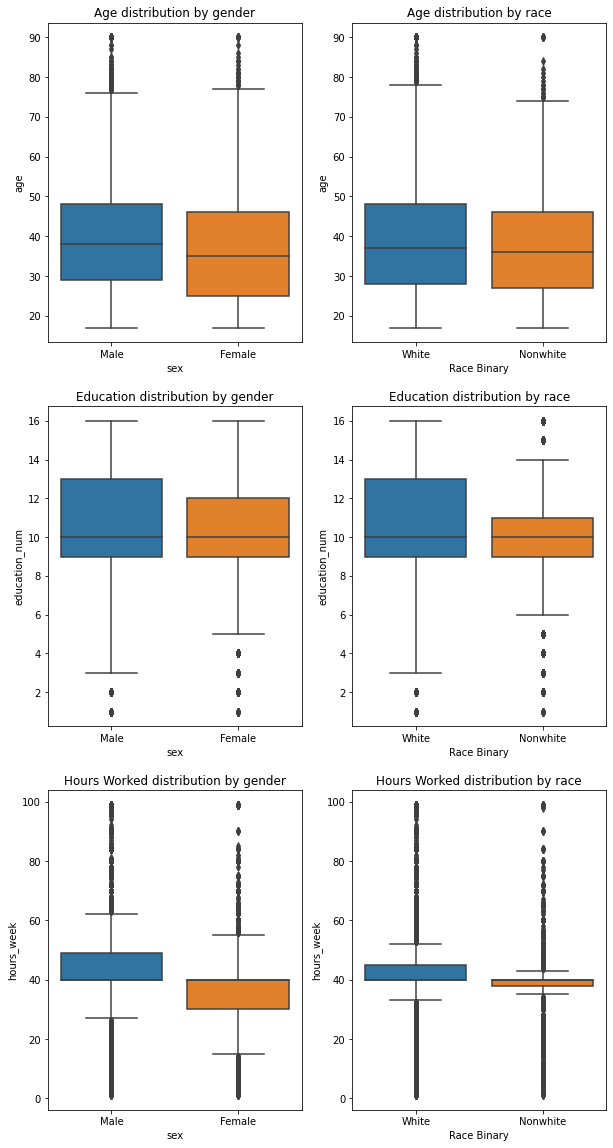

In [ ]:
# Plots
# Male vs. Female rate of income >50k
# White vs. nonwhite rate of income >50k
# Male v. Female education
# White vs. nonwhite education
# Male vs. female age
# White vs. nonwhite age

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(10, 20))
sns.boxplot(ax=axes[0,0], data=adult_data, x='sex', y='age').set_title('Age distribution by gender')
sns.boxplot(ax=axes[0,1], data=adult_data, x='Race Binary', y='age').set_title('Age distribution by race')
sns.boxplot(ax=axes[1,0], data=adult_data, x='sex', y='education_num').set_title('Education distribution by gender')
sns.boxplot(ax=axes[1,1], data=adult_data, x='Race Binary', y='education_num').set_title('Education distribution by race')
sns.boxplot(ax=axes[2,0], data=adult_data, x='sex', y='hours_week').set_title('Hours Worked distribution by gender')
sns.boxplot(ax=axes[2,1], data=adult_data, x='Race Binary', y='hours_week').set_title('Hours Worked distribution by race')



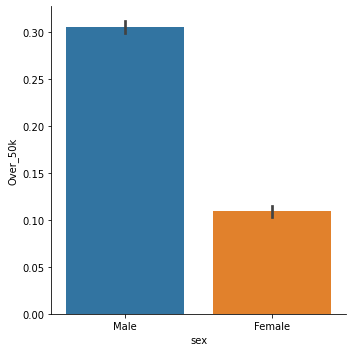

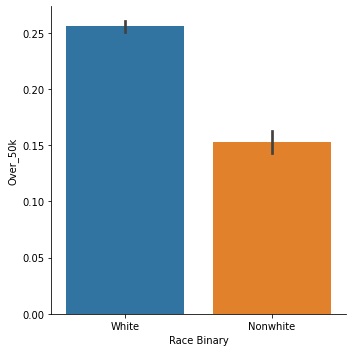

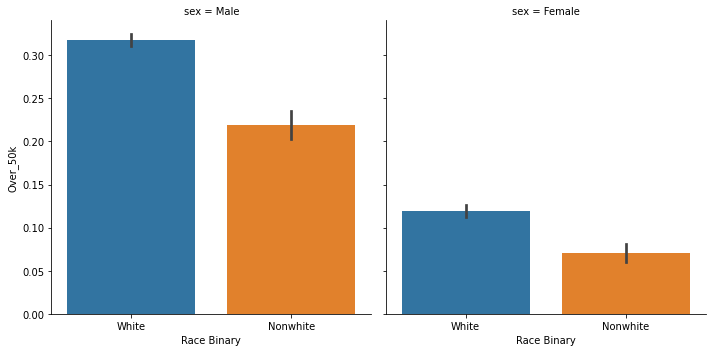

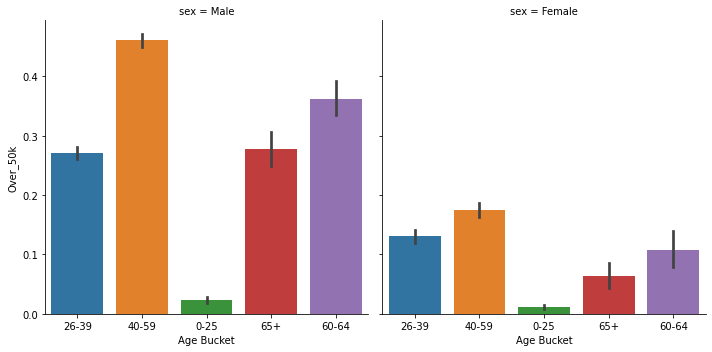

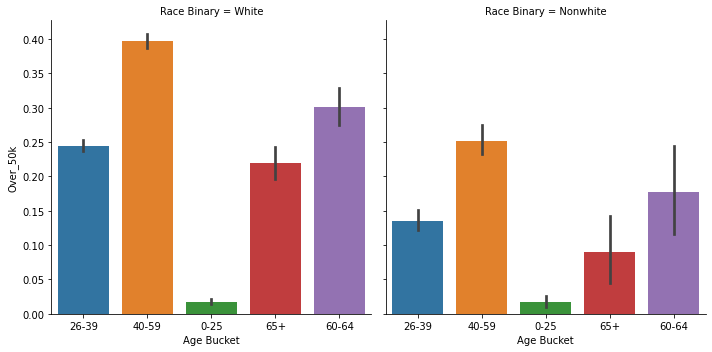

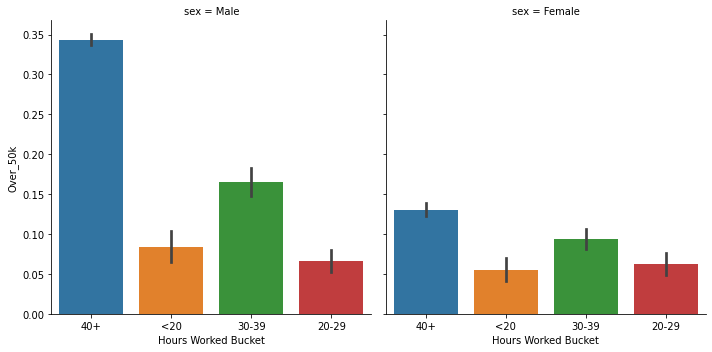

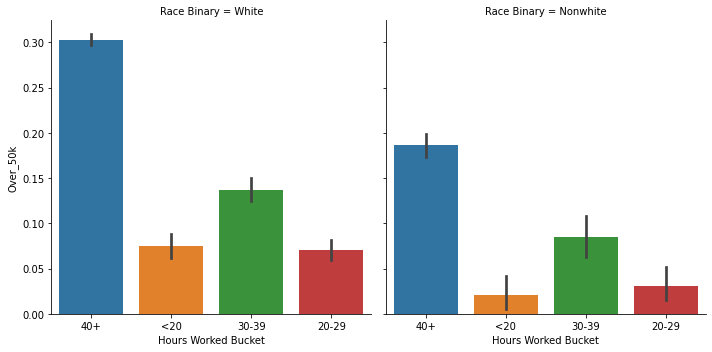

In [ ]:
# Plot outcome variable by Protected Attributes, also Age
sns.catplot(x="sex", y="Over_50k", kind="bar", data=adult_data)
sns.catplot(x="Race Binary", y="Over_50k", kind="bar", data=adult_data)

# Intersection
sns.catplot(x="Race Binary", y="Over_50k", kind="bar", data=adult_data, col="sex")

sns.catplot(x="Age Bucket", y="Over_50k", kind="bar", data=adult_data, col="sex")
sns.catplot(x="Age Bucket", y="Over_50k", kind="bar", data=adult_data, col="Race Binary")

sns.catplot(x="Hours Worked Bucket", y="Over_50k", kind="bar", data=adult_data, col="sex")
sns.catplot(x="Hours Worked Bucket", y="Over_50k", kind="bar", data=adult_data, col="Race Binary")


## 1.4 Binary classification pipeline

In [ ]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [ ]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs = axs.ravel()
    axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
    axs[0].set_ylabel("TPR")
    axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
    axs[1].set_ylabel("FPR")
    fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

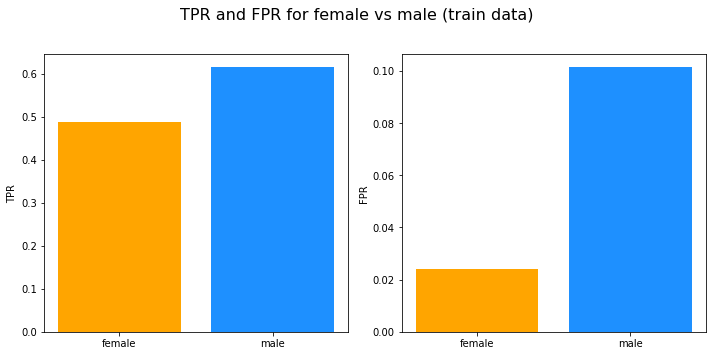

In [ ]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="train")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="train")

In [ ]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff = abs(TPR_f-TPR_m)

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff = abs(FPR_f-FPR_m)

# Demographic parity (FP + TP rate difference)
dem_parity = abs((FPR_f+TPR_f)-(FPR_m+TPR_m))

# Calculate overall accuracy for female and male
ACC_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity:.4f}")
print(f"The overall accuracy for female is: {ACC_f:.4f}")
print(f"The overall accuracy for male is: {ACC_m:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.1259
The difference in FPR (equalized odds) is: 0.0774
The difference in FP + TP rate (Demographic Parity) is: 0.2033
The overall accuracy for female is: 0.9208
The overall accuracy for male is: 0.8100


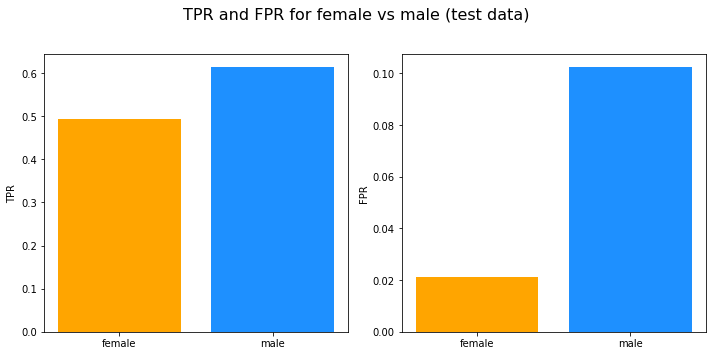

In [ ]:
# Run the binary classification pipeline on the original processed data and evaluation on test data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the test data for female and male
TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [ ]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff = abs(TPR_f-TPR_m)

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff = abs(FPR_f-FPR_m)

# Demographic parity (FP + TP rate difference)
dem_parity = abs((FPR_f+TPR_f)-(FPR_m+TPR_m))

# Calculate overall accuracy for female and male
ACC_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TEST DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity:.4f}")
print(f"The overall accuracy for female is: {ACC_f:.4f}")
print(f"The overall accuracy for male is: {ACC_m:.4f}")

TEST DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.1198
The difference in FPR (equalized odds) is: 0.0811
The difference in FP+ TP rate (Demographic Parity) is: 0.2010
The overall accuracy for female is: 0.9233
The overall accuracy for male is: 0.8067


**Proposed methodology going forward:**

$\text{Input: processed Adult data }D.\text{ Output: Lists of fairness distance metrics }\delta_{y=0},\delta_{y=1} \text{ for each } \epsilon.$ 
1. $\text{Randomly perform 80/20 split on }D\text{ into } D_{train},D_{test}.$ 
2. $\textbf{for } \epsilon=1.0,2.0,...,10.0:$
3. $\quad \text{Generate private training data } D'_{train} \text{ using synthesizer } S \text{ with privacy loss }\epsilon.$
4. $\quad \text{Reformat private } D'_{train} \text{ into } X'_{train},y'_{train} \text{ and non-private } D_{test} \text{ into } X_{test},y_{test}.$
5. $\quad \text{Apply binary classification pipeline to calculate } \delta_{y=0},\delta_{y=1} \text{ on test data}.$
6. $\textbf{end for}$
7. $\textbf{return} \text{ lists of } \delta_{y=0},\delta_{y=1} \text{ for each } \epsilon$


In [ ]:
# in each loop, could generate 5 synthetic datasets and average the results (see how much it varies)
# try running with balanced classes as well (not necessarily considered a pre-processing technique)

## 1.5 Hypothesis Testing Pipeline

In [ ]:
# Hypothesis Testing: Difference in proportions across privileged vs. non-privileged groups

def adult_hypothesis_test_gender_single_df(processed_data, sampling_distr_plots = True):
    '''
    Takes in: Processed adult dataset

    Returns: Hypothesis test results for difference in proportions between outcome (label) for groups

    Proportion of Interest: Share of individuals making more than $50k
    Null Hypothesis: Proportions from the two populations are the same
    Alternative Hypothesis: Proportions from the two populations are different
    '''
    print("Contingency Tables:")
    print("Counts:")
    contingency_table = pd.crosstab(processed_data.over_under_50k, processed_data.gender_labs).apply(lambda r:r/r.sum(),axis=0)
    print(tabulate(contingency_table, headers='keys', tablefmt='psql'))

    print('Proportions:')
    contingency_table_n = pd.crosstab(processed_data.over_under_50k, processed_data.gender_labs)
    print(tabulate(contingency_table_n, headers='keys', tablefmt='psql'))

    ns = processed_data.groupby('gender_labs').size()

    # Assign variables
    p_female = contingency_table['Female'][1]
    p_male = contingency_table['Male'][1]
    success_female = contingency_table_n['Female'][1]
    success_male = contingency_table_n['Male'][1]
    n_female = ns[0]
    n_male = ns[1]

    # Sampling distribution of sample proportions for men/women

    # Men first
    mu_male = p_male
    variance_male = p_male*(1-p_male)/n_male
    sigma_male = math.sqrt(variance_male)

    # Female
    mu_female = p_female
    variance_female = p_female*(1-p_female)/n_female
    sigma_female = math.sqrt(variance_female)

    if sampling_distr_plots:

        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        x1 = np.linspace(mu_male - 3*sigma_male, mu_male + 3*sigma_male, 100)
        x2 = np.linspace(mu_female - 3*sigma_female, mu_female + 3*sigma_female, 100)
        sns.lineplot(x = x1, y = norm.pdf(x1, mu_male, sigma_male), label = 'Male', ax=axes[0]).set_title("Sampling Distr. of Sample Prop: Men")
        sns.lineplot(x = x2, y = norm.pdf(x2, mu_female, sigma_female), label = "Female", ax = axes[1]).set_title("Sampling Distr. of Sample Prop: Women")

        # Sampling distribution of sample proportion for the difference between men and women

        mu = p_male-p_female
        variance = p_male*(1-p_male)/n_male + p_female*(1-p_female)/n_female
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        sns.lineplot(x = x, y = norm.pdf(x, mu, sigma), ax=axes[2]).set_title("Sampling Distr. of Sample Prop for the Dif between Men and Women")

    # Set significance level
    significance = 0.05

    # Assign samples
    sample_success_f, sample_size_f = (success_female, n_female)
    sample_success_m, sample_size_m = (success_male, n_male)

    successes = np.array([sample_success_f, sample_success_m])
    samples = np.array([sample_size_f, sample_size_m])
    print(f'Mean Difference in Rate of >50k Across genders: {round(mu,4)}')
    # Perform 2-sided test
    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # Print out results
    print("Results of Difference in Proportions Test:")
    print('z_statistic: %0.3f, p_value: %0.3f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis of no difference")
    else:
        print ("Reject the null hypothesis - Suggests proportions from the two populations are different")

    # Calculate confints
    mean_dif = mu_male - mu_female
    se_male = np.sqrt(mu_male * (1 - mu_male) / n_male)
    se_female = np.sqrt(mu_female * (1 - mu_female) / n_female)
    se_dif = np.sqrt(se_female**2 + se_male**2)
    lcb = mean_dif - 1.96*se_dif  #lower limit of the CI
    ucb = mean_dif + 1.96*se_dif  #upper limit of the CI
    print('Confidence Interval for Dif. in Proportions:')
    print((lcb, ucb))


In [ ]:
# Hypothesis Testing: Difference in proportions across privileged vs. non-privileged groups

def adult_hypothesis_test_race_single_df(processed_data, sampling_distr_plots = True):
    '''
    Takes in: Processed adult dataset

    Returns: Hypothesis test results for difference in proportions between outcome (label) for groups

    Proportion of Interest: Share of individuals making more than $50k
    Null Hypothesis: Proportions from the two populations are the same
    Alternative Hypothesis: Proportions from the two populations are different
    '''
    print("Contingency Tables:")
    print("Counts:")
    contingency_table = pd.crosstab(processed_data.over_under_50k, processed_data.race_White).apply(lambda r:r/r.sum(),axis=0)
    print(tabulate(contingency_table, headers='keys', tablefmt='psql'))

    print('Proportions:')
    contingency_table_n = pd.crosstab(processed_data.over_under_50k, processed_data.race_White)
    print(tabulate(contingency_table_n, headers='keys', tablefmt='psql'))

    ns = processed_data.groupby('race_White').size()

    # Assign variables
    p_white = contingency_table[1][1]
    p_nonwhite = contingency_table[0][1]
    success_white = contingency_table_n[1][1]
    success_nonwhite = contingency_table_n[0][1]
    n_white = ns[0]
    n_nonwhite = ns[1]

    # Sampling distribution of sample proportions for men/women

    # White first
    mu_white = p_white
    variance_white = p_white*(1-p_white)/n_white
    sigma_white = math.sqrt(variance_white)

    # Nonwhite
    mu_nonwhite = p_nonwhite
    variance_nonwhite = p_nonwhite*(1-p_nonwhite)/n_nonwhite
    sigma_nonwhite = math.sqrt(variance_nonwhite)

    if sampling_distr_plots:

        fig, axes = plt.subplots(1, 3, figsize=(20, 5))

        x1 = np.linspace(mu_white - 3*sigma_white, mu_white + 3*sigma_white, 100)
        x2 = np.linspace(mu_nonwhite - 3*sigma_nonwhite, mu_nonwhite + 3*sigma_nonwhite, 100)
        sns.lineplot(x = x1, y = norm.pdf(x1, mu_white, sigma_white), label = 'White', ax=axes[0]).set_title("Sampling Distr. of Sample Prop: White")
        sns.lineplot(x = x2, y = norm.pdf(x2, mu_nonwhite, sigma_nonwhite), label = "Nonwhite", ax = axes[1]).set_title("Sampling Distr. of Sample Prop: Nonwhite")

        # Sampling distribution of sample proportion for the difference between men and women

        mu = p_white-p_nonwhite
        variance = p_white*(1-p_white)/n_white + p_nonwhite*(1-p_nonwhite)/n_nonwhite
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        sns.lineplot(x = x, y = norm.pdf(x, mu, sigma), ax=axes[2]).set_title("Sampling Distr. of Sample Prop for the Dif between White and Nonwhite")

    # Set significance level
    significance = 0.05

    # Assign samples
    sample_success_w, sample_size_w = (success_white, n_white)
    sample_success_nw, sample_size_nw = (success_nonwhite, n_nonwhite)

    successes = np.array([sample_success_w, sample_success_nw])
    samples = np.array([sample_size_w, sample_size_nw])
    print(f'Mean Difference in Rate of >50k Across White vs. Nonwhite: {round(mu,4)}')
    # Perform 2-sided test
    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # Print out results
    print("Results of Difference in Proportions Test:")
    print('z_statistic: %0.3f, p_value: %0.3f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis of no difference")
    else:
        print ("Reject the null hypothesis - Suggests proportions from the two populations are different")

    # Calculate confints
    mean_dif = mu_white - mu_nonwhite
    se_white = np.sqrt(mu_white * (1 - mu_white) / n_white)
    se_nonwhite = np.sqrt(mu_nonwhite * (1 - mu_nonwhite) / n_nonwhite)
    se_dif = np.sqrt(se_nonwhite**2 + se_white**2)
    lcb = mean_dif - 1.96*se_dif  #lower limit of the CI
    ucb = mean_dif + 1.96*se_dif  #upper limit of the CI
    print('Confidence Interval for Dif. in Proportions:')
    print((lcb, ucb))

Contingency Tables:
Counts:
+------------------+----------+----------+
|   over_under_50k |   Female |     Male |
|------------------+----------+----------|
|                0 | 0.886506 | 0.686213 |
|                1 | 0.113494 | 0.313787 |
+------------------+----------+----------+
Proportions:
+------------------+----------+--------+
|   over_under_50k |   Female |   Male |
|------------------+----------+--------|
|                0 |     8803 |  14265 |
|                1 |     1127 |   6523 |
+------------------+----------+--------+
Mean Difference in Rate of >50k Across genders: 0.2003
Results of Difference in Proportions Test:
z_statistic: -37.967, p_value: 0.000
Reject the null hypothesis - Suggests proportions from the two populations are different
0.1134944612286002
0.31378680007696746
Confidence Interval for Dif. in Proportions:
(0.19142014062846108, 0.20916453706827348)


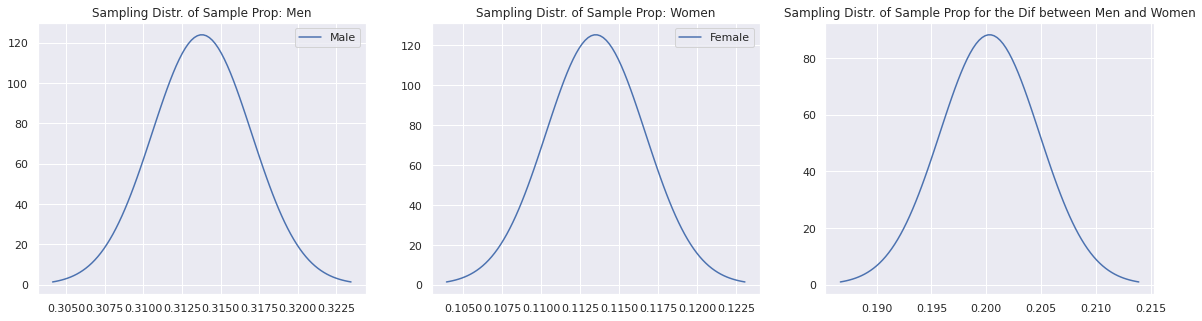

In [ ]:
# Execute for gender
adult_hypothesis_test_gender_single_df(processed_adult, sampling_distr_plots = True)

Contingency Tables:
Counts:
+------------------+----------+---------+
|   over_under_50k |        0 |       1 |
|------------------+----------+---------|
|                0 | 0.840163 | 0.73598 |
|                1 | 0.159837 | 0.26402 |
+------------------+----------+---------+
Proportions:
+------------------+------+-------+
|   over_under_50k |    0 |     1 |
|------------------+------+-------|
|                0 | 3711 | 19357 |
|                1 |  706 |  6944 |
+------------------+------+-------+
0.26402037945325274
0.15983699343445779
Mean Difference in Rate of >50k Across White vs. Nonwhite: 0.1042
Results of Difference in Proportions Test:
z_statistic: 219.742, p_value: 0.000
Reject the null hypothesis - Suggests proportions from the two populations are different
Confidence Interval for Dif. in Proportions:
(0.09044966272773486, 0.11791710930985505)


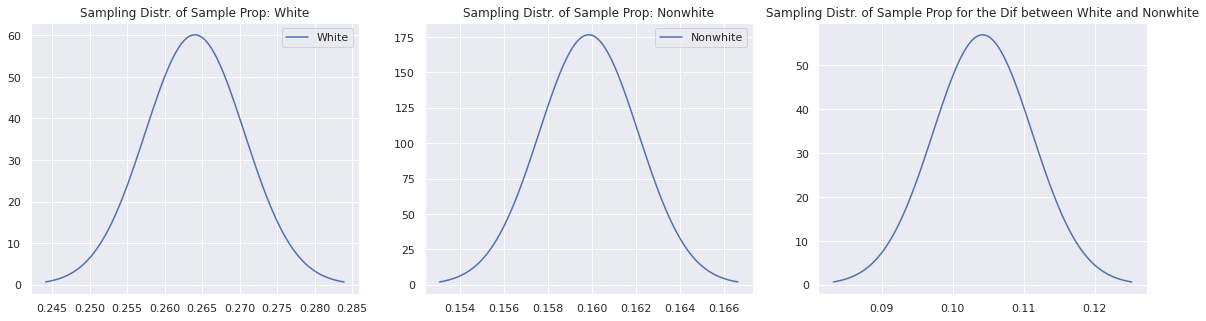

In [ ]:
adult_hypothesis_test_race_single_df(processed_adult, sampling_distr_plots = True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa928c63-0856-4021-a156-02d09e35182a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>